In [58]:
suppressPackageStartupMessages(suppressWarnings({
    library(rhdf5)
    library(Matrix)
    library(CytoTRACE)
    library(ggplot2)
}))

In [5]:
prj.dir <- "/scratch/gpfs/KANG/sereno/spatialstem"
src.dir <- file.path(prj.dir, "sourcefiles")
raw.dir <- file.path(src.dir, "raw")
had.dir <- file.path(src.dir, "h5ad")
int.dir <- file.path(prj.dir, "intermediates")
fig.dir <- file.path(prj.dir, "figs")
csv.dir <- file.path(src.dir, "csv")
exp.dir <- file.path(csv.dir, "exp")
cor.dir <- file.path(csv.dir, "coords")

In [42]:
# Function for opening an h5ad file as a formatted 10x object.
exp.files <- list.files(exp.dir)
exp.paths <- paste0(exp.dir, "/", exp.files)
cor.files <- list.files(cor.dir)
cor.paths <- paste0(cor.dir, "/", cor.files)

In [43]:
exp.path <- exp.paths[1]
cor.path <- cor.paths[1]
print(exp.path)
print(cor.path)

[1] "/scratch/gpfs/KANG/sereno/spatialstem/sourcefiles/csv/exp/p01_fetalliver_exp.csv"
[1] "/scratch/gpfs/KANG/sereno/spatialstem/sourcefiles/csv/coords/p01_fetalliver_coords.csv"


In [35]:
# Load in expression data
expr <- data.frame(read.table(exp.path, header=TRUE, sep=","))
gene.names <- expr[, 1]

In [36]:
# Remove duplicate gene rows and reformat matrix.
duped.genes <- duplicated(gene.names)
expr.filt <- expr[!duped.genes, ]
rownames(expr.filt) <- expr.filt[, 1]
expr.filt[, 1] <- NULL
colnames(expr.filt) <- gsub("X", "", colnames(expr.filt))

In [39]:
n.cells <- ncol(expr.filt)
ct.results <- CytoTRACE(expr.filt, ncores=16, enableFast=FALSE)
ct.vals <- ct.results$CytoTRACE

The number of cells in your dataset exceeds 3,000. CytoTRACE will now be run in fast mode (see documentation). You can multi-thread this run using the 'ncores' flag. To disable fast mode, please indicate 'enableFast = FALSE'.

Warning message in CytoTRACE(expr.filt, ncores = 16, enableFast = FALSE):
“685 genes have zero expression in the matrix and were filtered”
CytoTRACE will be run on 1 sub-sample(s) of approximately 7295 cells each using 1 / 16 core(s)

Pre-processing data and generating similarity matrix...

Calculating gene counts signature...

Smoothing values with NNLS regression and diffusion...

Calculating genes associated with CytoTRACE...

Done



In [51]:
coords <- read.table(cor.path, header=FALSE, sep=",")

In [53]:
ct.df <- data.frame(x=coords[, 1], y=coords[, 2], cytotrace=ct.vals)

,x,y,cytotrace
,<dbl>,<dbl>,<dbl>
1,3210.241,2438.246,0.67008310
2,6956.573,5176.669,0.45443213
3,6091.637,2823.184,0.92396122
4,2327.439,2663.424,0.01551247
5,3614.936,1841.927,0.34958449
6,2896.820,1423.360,0.88601108


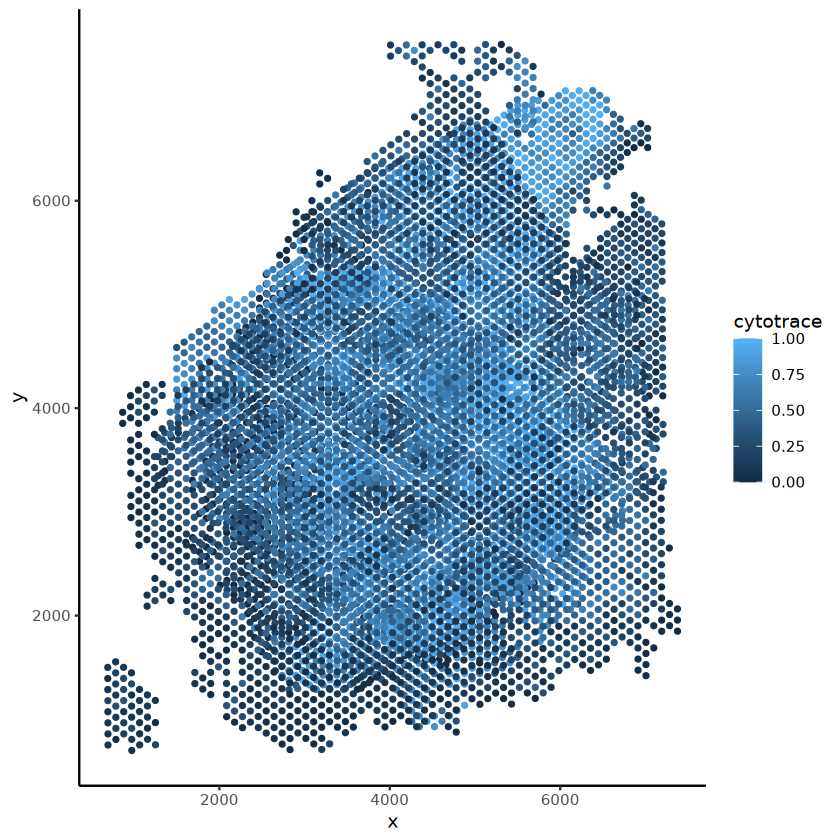

In [60]:
ggplot(data=ct.df, aes(x=x, y=y, color=cytotrace)) + 
    geom_point(size=1) + 
    theme_classic()